In [1]:
import tidy3d as td
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time

12:03:47 CET WARNING: Using canonical configuration directory at                
             '/home/marc/.config/tidy3d'. Found legacy directory at '~/.tidy3d',
             which will be ignored. Remove it manually or run 'tidy3d config    
             migrate --delete-legacy' to clean up.                              

## Problem setup

In [2]:
# Physical parameters
L = 1
C0 = 1e17 * 1e-12 # um^-3
T0 = 300 # K
vt0 = td.K_B * T0 # V
mu0 = 1500 * 1e8 # um2/(Vs)
Er = 5 # relative permittivity
Vmax = 1 # V
t0 = L*L/Vmax/mu0 # seconds

mu_n = 1500 * 1e8 / mu0
mu_p = 500 * 1e8 / mu0
tau_n = tau_p = 1e-10 / t0
Eg = 1.12 / Vmax # non-dimenal energy bandgap

ni = 1e10 * 1e-12 / C0

# Numerical parameters
N = 50 # NUmber of "grid" nodes
dx = L / (N - 1) / L # dimensionless grid spacing

T = 300 * np.ones(N) / T0

vt0_bar = vt0 / Vmax

eps0 = td.EPSILON_0 * vt0 / (td.Q_e * C0 * L * L)
eps0 = td.EPSILON_0 * Vmax / (td.Q_e * C0 * L * L)
print(f"eps0 {eps0:0.3e}")

R0 = mu0 * Vmax * C0 / L / L
print(f"R0 {R0:0.3e} 1/(um³s)")
print(f"t0 {t0:0.3e}")
print(f"dx {dx:0.3e}$")
print(f"Vmax {Vmax:0.3e} V; Vt0 {vt0:0.3e} V, vt0_bar {vt0_bar:0.3e}")

eps0 5.526e-04
R0 1.500e+16 1/(um³s)
t0 6.667e-12
dx 2.041e-02$
Vmax 1.000e+00 V; Vt0 2.585e-02 V, vt0_bar 2.585e-02


## Bernoulli function

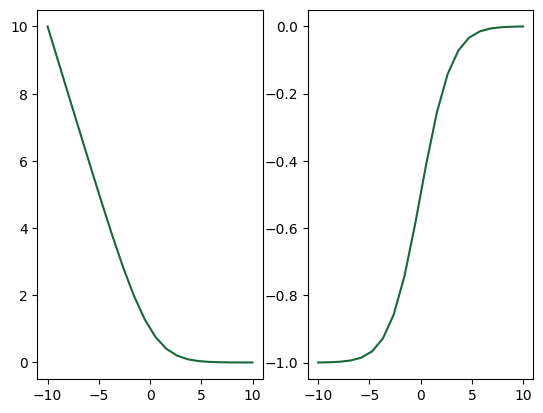

In [3]:
def B(x):
    if np.isclose(x, 0.0):
        return 1
    else:
        return x/(np.exp(x) - 1)

def dB(x):
    if np.isclose(x, 0.0):
        return 0.5
    else:
        return (np.exp(x)*(1-x) - 1)/(np.exp(x) - 1)/(np.exp(x) - 1)

_, ax = plt.subplots(1, 2)
ax[0].plot(np.linspace(-10,10,20), [B(x) for x in np.linspace(-10,10,20)])
ax[1].plot(np.linspace(-10,10,20), [dB(x) for x in np.linspace(-10,10,20)])
plt.show()

## Build matrix

In [4]:
def plus_minus_indeces(i):
    ip1 = i + 1
    im1 = i - 1
    if i == N - 1:
        ip1 = 0
    if i == 0:
        im1 = N - 1
    return ip1, im1

def compute_jacobian(J, U, T):
    # reset jacobian 
    J.fill(0)

    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]
    
    # fill in Gauss equation terms
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)
        
        J[i,im1] = - eps0 * Er / dx
        J[i,i] = 2 * eps0 * Er / dx
        J[i,ip1] = - eps0 * Er / dx
    
        # p and n terms
        # J[i, N + i] = dx
        # J[i, 2*N + i] = - dx
    
    # fill in conservation eqs.
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)
        
        F_n1_2 = -(phi[i] - phi[im1]) / dx + vt0_bar * (T[i] - T[im1]) / dx
        F_1_2  = -(phi[ip1] - phi[i]) / dx + vt0_bar * (T[ip1] - T[i]) / dx

        Fp_n1_2 = -(phi[i] - phi[im1]) / dx - vt0_bar * (T[i] - T[im1]) / dx
        Fp_1_2  = -(phi[ip1] - phi[i]) / dx - vt0_bar * (T[ip1] - T[i]) / dx
        
        T_n1_2 = 0.5 * (T[im1] + T[i])
        T_1_2 = 0.5 * (T[ip1] + T[i])
    
        # # phi terms - n equation
        # J[N+i,im1] += U[N+im1]*dB(mu_n * F_n1_2 * dx / T) * mu_n
        # J[N+i,i] += - U[N+im1]*dB(mu_n * F_n1_2 * dx / T) * mu_n
        
        # J[N+i,im1] += U[N+i] * mu_n * dB(-mu_n * F_n1_2 * dx / T)
        # J[N+i,i] += -U[N+i] * mu_n *(dB(mu_n * F_1_2 * dx / T) + dB(-mu_n * F_n1_2 * dx / T))
        # J[N+i,ip1] += U[N+i] * mu_n * dB(mu_n * F_1_2 * dx / T)
    
        # J[N+i,ip1] += U[N+ip1]*dB(-mu_n * F_n1_2 * dx / T) * mu_n            
        # J[N+i,i] += -U[N+ip1]*dB(-mu_n * F_n1_2 * dx / T) * mu_n
    
        # # phi terms - p equation
        # J[2*N+i,im1] += -U[2*N+im1] * mu_p * dB(-mu_p * F_n1_2 * dx / T)
        # J[2*N+i,i] += U[2*N+im1] * mu_p * dB(-mu_p * F_n1_2 * dx / T)
    
        # J[2*N+1,im1] += -U[2*N+i] * mu_p * dB(mu_p * F_n1_2 * dx / T)
        # J[2*N+1,i] += -U[2*N+i] * mu_p * (-dB(mu_p * F_n1_2 * dx / T) - dB(-mu_p * F_1_2 * dx / T))
        # J[2*N+1,ip1] += -U[2*N+i] * mu_p * dB(-mu_p * F_1_2 * dx / T)
    
        # J[2*N+1,i] += U[2*N+ip1] * mu_p * dB(mu_p * F_1_2 * dx / T)
        # J[2*N+1,ip1] += -U[2*N+ip1] * mu_p * dB(mu_p * F_1_2 * dx / T)
        
        # n terms
        J[N+i, N+im1] += -mu_n * vt0_bar * T_n1_2/dx * B(F_n1_2 * dx / T_n1_2 / vt0_bar)
        J[N+i, N+i] += mu_n * vt0_bar /dx * (T_1_2 * B(F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(-F_n1_2 * dx / T_n1_2 / vt0_bar))
        J[N+i, N+ip1] += -mu_n * vt0_bar * T_1_2/dx * B(-F_1_2 * dx / T_1_2 / vt0_bar)
    
        # p terms
        J[2*N+i, 2*N+im1] += - mu_p * vt0_bar * T_n1_2/dx * B(-Fp_n1_2 * dx / T_n1_2 / vt0_bar)
        J[2*N+i, 2*N+i] += mu_p * vt0_bar /dx * (T_1_2 * B(-Fp_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(Fp_n1_2 * dx / T_n1_2 / vt0_bar))
        J[2*N+i, 2*N+ip1] += - mu_p * vt0_bar * T_1_2/dx * B(Fp_1_2 * dx / T_1_2 / vt0_bar)
    return J

def source_term(S, U):
    S.fill(0)
    
    n = U[N:2*N]
    p = U[2*N:3*N]
    
    for i in range(N):
        S[i] = dx * (p[i] - n[i] - np.sin(2*np.pi*dx*i))

        # recombination terms
        R = C0/t0 / R0 * (n[i]*p[i] - ni*ni)/(tau_n*(n[i] + ni) + tau_p*(p[i] + ni))
        S[N + i] = - dx * R
        S[2*N + i] = - dx * R
    return S

def compute_source_jacobian(Js, U):
    Js.fill(0)

    n = U[N:2*N]
    p = U[2*N:3*N]

    for i in range(N):
        Js[i, N + i] = - dx
        Js[i, 2*N + i] = dx

        d = tau_n*(n[i] + ni) + tau_p*(p[i] + ni)

        Js[N + i, N + i] = -dx * C0/t0/R0 * (p[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_n)
        Js[N + i, 2*N + i] = -dx * C0/t0/R0 * (n[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_p)

        Js[2*N + i, N + i] = -dx * C0/t0/R0 * (p[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_n)
        Js[2*N + i, 2*N + i] = -dx * C0/t0/R0 * (n[i]/d - (n[i]*p[i] - ni*ni)/d/d*tau_p)
    return Js

## Matrices with AD

In [5]:
def flux_function(U, T, i):
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]
    
    # Fluxes for node i
    ip1, im1 = plus_minus_indeces(i)
        
    F_n1_2 = -(phi[i] - phi[im1]) / dx
    F_1_2  = -(phi[ip1] - phi[i]) / dx
    
    T_n1_2 = 0.5 * (T[im1] + T[i])
    T_1_2 = 0.5 * (T[ip1] + T[i])

    # flux Gauss
    flux_phi = - eps0 * Er / dx * (phi[ip1] - 2 * phi[i] + phi[im1])

    # flux n
    flux_n = -mu_n * vt0_bar * T_n1_2/dx * B(F_n1_2 * dx / T_n1_2 / vt0_bar) * n[im1]
    flux_n += mu_n * vt0_bar/dx * (T_1_2 * B(F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(-F_n1_2 * dx / T_n1_2 / vt0_bar)) * n[i]
    flux_n += -mu_n * vt0_bar * T_1_2/dx * B(-F_1_2 * dx / T_1_2 / vt0_bar) * n[ip1]

    # flux p
    flux_p = - mu_p * vt0_bar * T_n1_2/dx * B(-F_n1_2 * dx / T_n1_2 / vt0_bar) * p[im1]
    flux_p += mu_p * vt0_bar/dx * (T_1_2 * B(-F_1_2 * dx / T_1_2 / vt0_bar) + T_n1_2 * B(F_n1_2 * dx / T_n1_2 / vt0_bar)) * p[i]
    flux_p += - mu_p * vt0_bar * T_1_2/dx * B(F_1_2 * dx / T_1_2 / vt0_bar) * p[ip1]

    return [flux_phi, flux_n, flux_p]

def compute_jacobian_ad(J, U, T):
    J.fill(0)

    delta = 1e-3

    for i in range(N):
        for j in range(3*N):
            Up = U.copy()
            Um = U.copy()
            Up[j] = Up[j] + delta
            Um[j] = Um[j] - delta
            [fp_phi, fp_n, fp_p] = flux_function(Up, T, i)
            [fm_phi, fm_n, fm_p] = flux_function(Um, T, i)
            
            J[i, j] = (fp_phi - fm_phi) / (2 * delta)
            
            dFn_dU = (fp_n - fm_n) / (2 * delta)
            dFp_dU = (fp_p - fm_p) / (2 * delta)
            if np.abs(dFn_dU) > 1000:
                dFn_dU = 1000 * dFn_dU / np.abs(dFn_dU)
            if np.abs(dFp_dU) > 100:
                dFp_dU = 1000 * dFp_dU / np.abs(dFp_dU)
            
            J[N + i, j] = dFn_dU
            J[2*N + i, j] = dFp_dU
            # print(i, f"{fp_n:0.5e}, {fp_p:0.5e}, {fm_n:0.5e}, {fm_p:0.5e}. {J[N + i, j]:0.5e}, {J[2*N + i, j]:0.5e}")
    return J

def compute_source_jacobian_ad(Js, U):
    Js.fill(0)
    Sp = np.zeros(3*N)
    Sm = np.zeros(3*N)

    delta = 1e-5

    for i in range(N):
        for j in range(3*N):
            Up = U.copy()
            Um = U.copy()
            Up[j] = Up[j] + delta
            Um[j] = Um[j] - delta
            Sp = source_term(Sp, Up)
            Sm = source_term(Sm, Um)
            
            Js[i, j] = (Sp[i] - Sm[i]) / (2 * delta)
            Js[N + i, j] = (Sp[N + i] - Sm[N + i]) / (2 * delta)
            Js[2*N + i, j] = (Sp[2*N + i] - Sm[2*N + i]) / (2 * delta)
    return Js

## Initial solution

In [6]:
U = np.zeros(3*N)

def init_solution(U):
    U.fill(0)
    for i in range(N):
        c = np.sin(2*np.pi*dx*i)

        U[N + i] = ni
        U[2*N + i] = ni
        
        if c > 0:
            U[2*N + i] = ni + 0.8*c
        elif c < 0:
            U[N + i] = ni - 0.8 * c
    return U
    
U = init_solution(U)

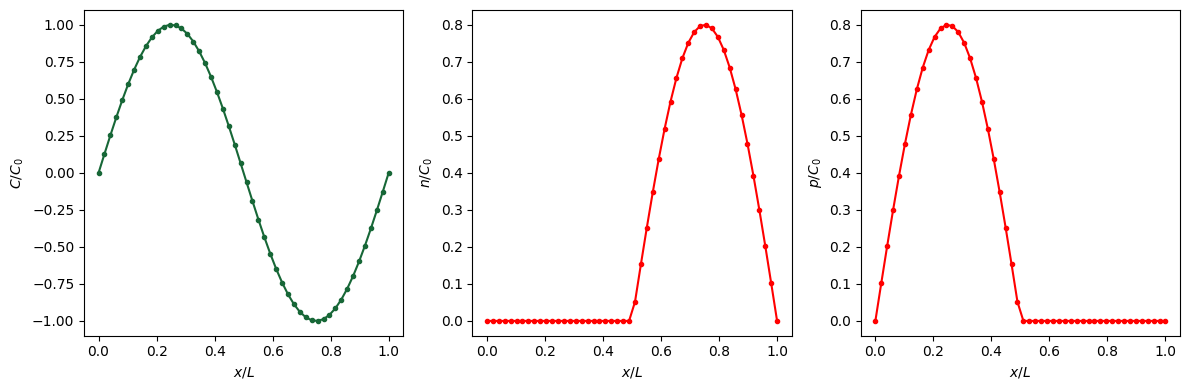

In [7]:
# Show doping and initial solution
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(np.linspace(0, 1, N), np.sin(2*np.pi*np.linspace(0, 1, N)), '.-')
ax[0].set_ylabel("$C/C_0$")

ax[1].plot(np.linspace(0, 1, N), U[N:2*N], 'r.-')
ax[1].set_ylabel("$n/C_0$")

ax[2].plot(np.linspace(0, 1, N), U[2*N:3*N], 'r.-')
ax[2].set_ylabel("$p/C_0$")

for i in range(3):
    ax[i].set_xlabel("$x/L$")
plt.tight_layout()
plt.show()

## Init Jacobians

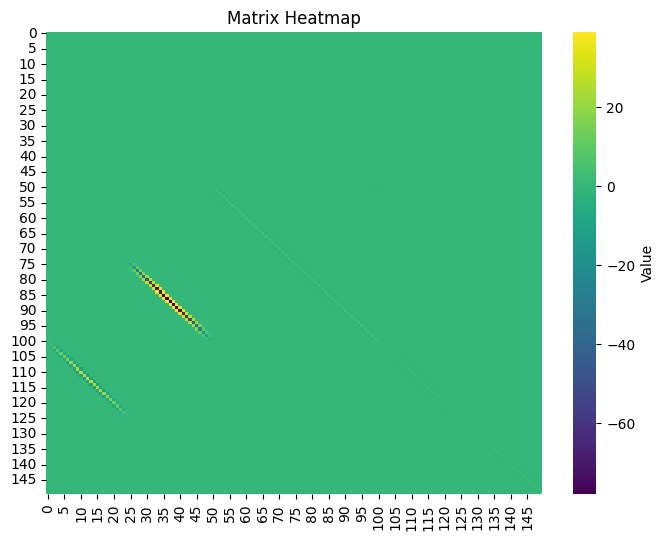

In [8]:
J = np.zeros([3*N,3*N])
J = compute_jacobian(J, U, T)

Jad = np.zeros([3*N,3*N])
Jad = compute_jacobian_ad(Jad, U, T)

diff_jac = np.abs(J - Jad)

Js = np.zeros([3*N,3*N])
Js = compute_source_jacobian(Js, U)

# Plot heatmap
plt.figure(figsize=(8, 6))
# sns.heatmap(np.abs(J), annot=False, cmap='viridis', cbar_kws={'label': 'Value'}, vmin=0, vmax=100)
# sns.heatmap(np.abs(J), annot=False, cmap='viridis', cbar_kws={'label': 'Value'}, vmin=0)
sns.heatmap(Jad, annot=False, cmap='viridis', cbar_kws={'label': 'Value'})
plt.title("Matrix Heatmap")
plt.show()

In [9]:
# visualize solution
def plot_solution(U, T):
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]
    _, ax = plt.subplots(1, 4, figsize=(12, 4))
    ax[0].plot(np.linspace(0,1,N), phi, 'k.-')
    ax[0].set_ylabel("$\psi/V$")
    
    ax[1].semilogy(np.linspace(0,1,N), n, 'r.-')
    ax[1].set_ylabel("$n/C_0$")
    
    ax[2].semilogy(np.linspace(0,1,N), p, 'b.-')
    ax[2].set_ylabel("$p/C_0$")
    
    ax[3].plot(np.linspace(0,1,N), T, 'c.-')
    ax[3].set_ylabel("$T/T_0$")

    for i in range(4):
        ax[i].set_xlabel("$x/L$")
    
    plt.tight_layout()
    plt.show()

## Solve with Jacobi method

In [10]:
def calc_rhs(S, J, U):
    return S - np.dot(J, U)
    
def updated_sol(U, dU):
    U2 = U.copy()
    U2 = U2 + dU

    # check n and p are >= 0
    for i in range(2*N):
        if U2[N + i] < 0:
            U2[N + i] = 0.1 * U[N + i]
    return U2

def matrix_minus_diagonal(M):
    # matrix to return
    R = M.copy()
    for i in range(M.shape[0]):
        R[i,i] = 0
    return R

def diagonal(M):
    d = np.diag(M).copy()
    for i in range(d.shape[0]):
        if np.isclose(d[i], 0.0):
            d[i] = 1e-5
    return d    

def solve_jacobi_3_eq(U, J, relaxation = 0.3):
    N_max = 10000
    err_max = 1e-6

    # history
    err_phi = []
    err_n = []
    err_p = []

    # init jacobi
    err = 1e10
    k = 0
    dU = np.zeros(3*N)
    S = np.zeros(3*N)
    Js = np.zeros([3*N, 3*N])
    U = init_solution(U)

    # jacobi iterations
    while err > err_max and k < N_max:
        # if k % 10 == 0:
        #     J = compute_jacobian_ad(J, U)
        J = compute_jacobian(J, U, T)
        S = source_term(S, U)
        Js = compute_source_jacobian(Js, U)

        A = J - Js
        
        rhs = calc_rhs(S, J, U)
        D = diagonal(A)
        dU = relaxation * (rhs - np.dot(matrix_minus_diagonal(A),dU)) / D
        dU[0] = 0
        U = updated_sol(U, dU)
        # plot_solution(U)

        # error history
        err_phi.append(np.linalg.norm(dU[0:N]))
        err_n.append(np.linalg.norm(dU[N:2*N]))
        err_p.append(np.linalg.norm(dU[2*N:3*N]))
        err = np.linalg.norm(dU)
        if k % 100 == 0:
            dphi = np.linalg.norm(dU[0:N])
            dn = np.linalg.norm(dU[N:2*N])
            dp = np.linalg.norm(dU[2*N:3*N])
            print(f"Jacobi iter {k} == Norm error {err:0.3e} ---- Min {np.min(np.abs(err)):0.3e}, Max {np.max(np.abs(err)):0.3e}, ")
            print(f"\tpsi {np.linalg.norm(dphi):0.3e} ---- Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn   {np.linalg.norm(dn):0.3e} ---- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp   {np.linalg.norm(dp):0.3e} ---- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
        k += 1

    # print convergence history
    plt.semilogy(err_phi, 'k.-', label="$\psi$")
    plt.semilogy(err_n, 'r.-', label="$n$")
    plt.semilogy(err_p, 'b.-', label="$p$")
    plt.xlabel("iters")
    plt.ylabel("$|\Delta U_i|$")
    plt.legend()
    return U

Jacobi iter 0 == Norm error 3.604e-02 ---- Min 3.604e-02, Max 3.604e-02, 
	psi 2.238e-02 ---- Min 2.238e-02, Max 2.238e-02
	n   1.998e-02 ---- Min 1.998e-02, Max 1.998e-02
	p   1.997e-02 ---- Min 1.997e-02, Max 1.997e-02
Jacobi iter 100 == Norm error 1.501e-02 ---- Min 1.501e-02, Max 1.501e-02, 
	psi 1.446e-02 ---- Min 1.446e-02, Max 1.446e-02
	n   2.831e-03 ---- Min 2.831e-03, Max 2.831e-03
	p   2.868e-03 ---- Min 2.868e-03, Max 2.868e-03
Jacobi iter 200 == Norm error 8.769e-03 ---- Min 8.769e-03, Max 8.769e-03, 
	psi 8.541e-03 ---- Min 8.541e-03, Max 8.541e-03
	n   1.393e-03 ---- Min 1.393e-03, Max 1.393e-03
	p   1.419e-03 ---- Min 1.419e-03, Max 1.419e-03
Jacobi iter 300 == Norm error 5.411e-03 ---- Min 5.411e-03, Max 5.411e-03, 
	psi 5.280e-03 ---- Min 5.280e-03, Max 5.280e-03
	n   8.517e-04 ---- Min 8.517e-04, Max 8.517e-04
	p   8.215e-04 ---- Min 8.215e-04, Max 8.215e-04
Jacobi iter 400 == Norm error 3.429e-03 ---- Min 3.429e-03, Max 3.429e-03, 
	psi 3.350e-03 ---- Min 3.350e-03,

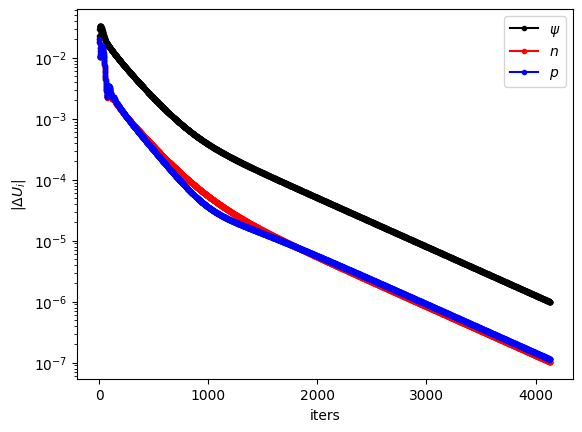

In [11]:
jac_time = time.time()
U_jac = solve_jacobi_3_eq(U,J, relaxation=0.3)
jac_time = time.time() - jac_time

## Solution Jacobi

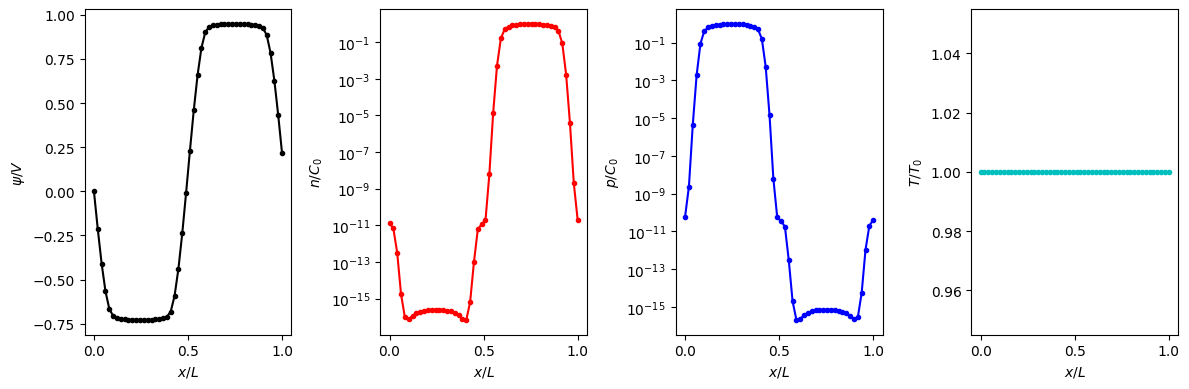

In [12]:
plot_solution(U_jac, T)

## Eigenvalues

Egenvalues:
Min (-5.196422037591381e-15+0j), max (5.066991958055985+0j), norm 23.246141118197 prod (-3.435037764214513e-92+0j)


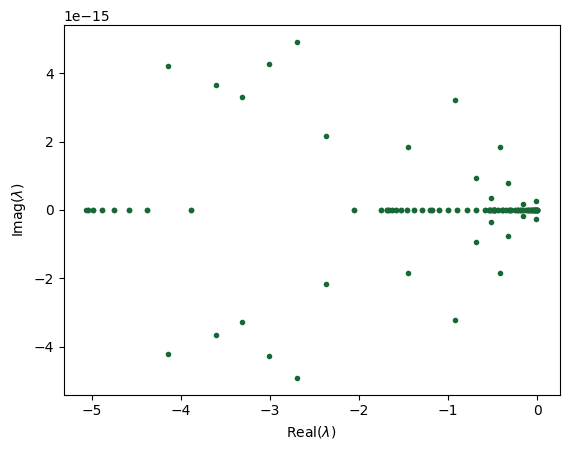

In [13]:
# Compute eigenvalues and eigenvectors
J = compute_jacobian(J, U, T)
Jad = compute_jacobian_ad(Jad, U, T)
eigenvalues, eigenvectors = np.linalg.eig(Jad)

print("Egenvalues:")
print(f"Min {np.min(eigenvalues)}, max {np.max(eigenvalues)}, norm {np.linalg.norm(eigenvalues)} prod {np.prod(eigenvalues)}")
plt.plot(-np.real(eigenvalues), np.imag(eigenvalues), '.')
plt.xlabel("Real($\lambda$)")
plt.ylabel("Imag($\lambda$)")
plt.show()

## Jacobi solver

In [14]:
def solve_jacobi(A, B, X, relaxation = 0.3, verbose = False, max_iters = 1e4, err_max = 1e-5):
    N_max = max_iters

    # init jacobi
    err = 1e10
    k = 0

    err_hist = []

    D = diagonal(A)
    dX = np.zeros(X.shape)

    # jacobi iterations
    while err > err_max and k < N_max:
        rhs = B - np.dot(A, X)
        dX = relaxation * (rhs - np.dot(matrix_minus_diagonal(A),dX)) / D
        X = X + dX
        # dU[0] = 0

        # error history
        err = np.linalg.norm(dX)
        err_hist.append(err)
        if k % 100 == 0 and verbose:
            print(f"Jacobi iter {k} == Norm error {err:0.3e} ---- Min {np.min(np.abs(err)):0.3e}, Max {np.max(np.abs(err)):0.3e}, ")
        k += 1

    # print convergence history
    if verbose:
        plt.semilogy(err_hist, 'k.-')
        plt.show()
    return X, k

## One system with pseudo-time stepping
The above system doesn't converge out of the bat. Gauss and charge conservation equations need to be solved simultaneously. Here I try with a pseudo-time step approach

In [15]:
def solve_pseudo_time():

    def plot_hist():
        plt.semilogy(err_phi, 'k.-', label="$\psi$")
        plt.semilogy(err_n, 'r.-', label="$n$")
        plt.semilogy(err_p, 'b.-', label="$p$")
        plt.xlabel("iters")
        plt.ylabel("$|\Delta U_i|$")
        plt.legend()
        plt.show()
    
    # init vars
    U = np.zeros(3*N)
    U = init_solution(U)
    
    J = np.zeros([3*N,3*N])
    S = np.zeros(3*N)
    Js = np.zeros([3*N,3*N])
    
    
    dU = np.zeros(3*N)

    # Pseudo-time stepping vars
    Nmax = 1000 # maximum pseudo-time iterations
    n = 0 # pseudo-time iteration
    total_jacobi_subiters = 0
    err_max = 1e-6
    err = 1e20
    CFL = 0.7 
    if np.isclose(vt0, Vmax):
        lambda_max = 4*dx/np.pi/np.pi/eps0 # estimated largest eigenvalue
    else:
        lambda_max = 1 / dx
    lambda_max = 1 / dx
    dt = CFL * dx / lambda_max # pseudo time step
    
    # error history
    err_phi = []
    err_n = []
    err_p = []

    # peseudo time mass matrix
    M = dx/dt*np.eye(3*N)
    for i in range(N):
        M[i,i] = dx / dt * eps0

    while n < Nmax and err > err_max:
        J = compute_jacobian(J, U, T)
        S = source_term(S, U)
        Js = compute_source_jacobian(Js, U)
        
        A = M + J - Js
        rhs = S - np.dot(J, U)
        
        dU, jac_iters = solve_jacobi(A, rhs, dU, relaxation = 0.35, verbose=False, max_iters=100, err_max = err_max / 10)
        dU[0] = 0

        err = np.linalg.norm(dU)
        if err > 1e5:
            print("This is very likely diverging!")
            plot_hist()
            return U
            
        # error history
        err_phi.append(np.linalg.norm(dU[0:N]))
        err_n.append(np.linalg.norm(dU[N:2*N]))
        err_p.append(np.linalg.norm(dU[2*N:3*N]))
        total_jacobi_subiters += jac_iters
        if n % 100 == 0:
            dphi = np.linalg.norm(dU[0:N])
            dn = np.linalg.norm(dU[N:2*N])
            dp = np.linalg.norm(dU[2*N:3*N])
            print(f"Pseudo time step {n} == Norm error {err:0.3e} ---- Total Jacobi sub-iterations {total_jacobi_subiters} ")
            print(f"\tpsi {np.linalg.norm(dphi):0.3e} ---- Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn   {np.linalg.norm(dn):0.3e} ---- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp   {np.linalg.norm(dp):0.3e} ---- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
        
        U = U + dU
        n += 1
    # print convergence history
    plot_hist()
    return U

Pseudo time step 0 == Norm error 4.947e-01 ---- Total Jacobi sub-iterations 100 
	psi 4.947e-01 ---- Min 4.947e-01, Max 4.947e-01
	n   2.349e-03 ---- Min 2.349e-03, Max 2.349e-03
	p   7.964e-04 ---- Min 7.964e-04, Max 7.964e-04
Pseudo time step 100 == Norm error 1.465e-02 ---- Total Jacobi sub-iterations 10100 
	psi 1.401e-02 ---- Min 1.401e-02, Max 1.401e-02
	n   1.170e-03 ---- Min 1.170e-03, Max 1.170e-03
	p   4.117e-03 ---- Min 4.117e-03, Max 4.117e-03
Pseudo time step 200 == Norm error 2.719e-03 ---- Total Jacobi sub-iterations 20100 
	psi 2.555e-03 ---- Min 2.555e-03, Max 2.555e-03
	n   4.713e-05 ---- Min 4.713e-05, Max 4.713e-05
	p   9.282e-04 ---- Min 9.282e-04, Max 9.282e-04
Pseudo time step 300 == Norm error 7.848e-04 ---- Total Jacobi sub-iterations 30100 
	psi 7.613e-04 ---- Min 7.613e-04, Max 7.613e-04
	n   2.508e-05 ---- Min 2.508e-05, Max 2.508e-05
	p   1.890e-04 ---- Min 1.890e-04, Max 1.890e-04
Pseudo time step 400 == Norm error 1.995e-04 ---- Total Jacobi sub-iteration

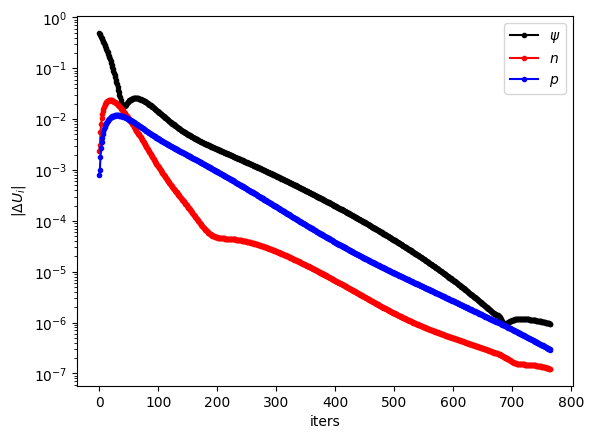

In [16]:
pt_time = time.time()
U_pt = solve_pseudo_time()
pt_time = time.time() - pt_time

Jacobi time 18.343680381774902
Pseudo time step time 4.613481760025024


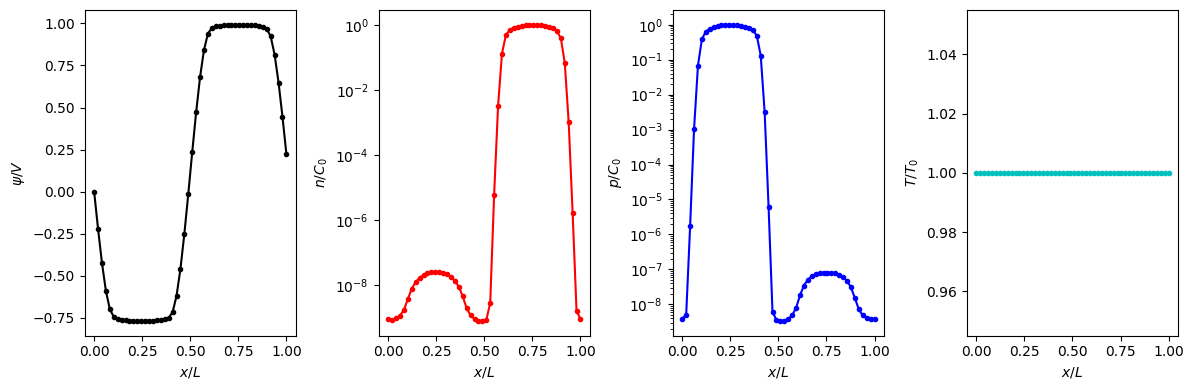

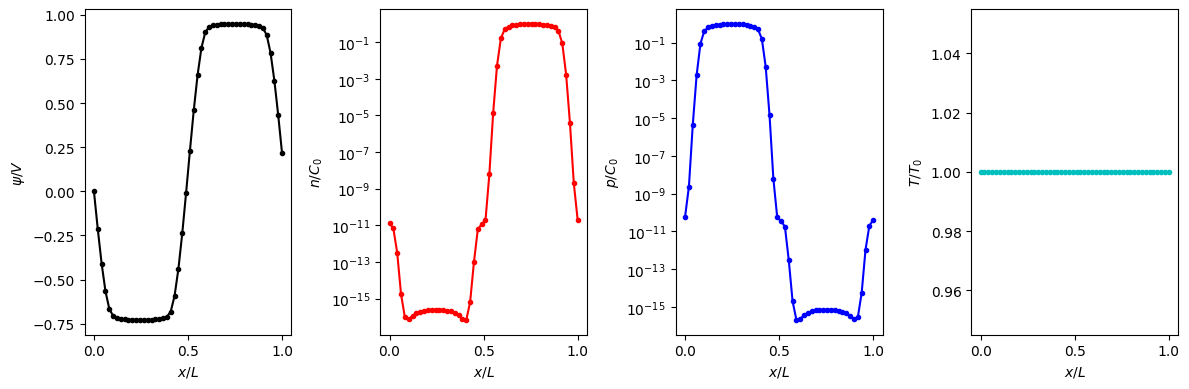

In [17]:
print(f"Jacobi time {jac_time}")
print(f"Pseudo time step time {pt_time}")
plot_solution(U_pt, T)
plot_solution(U_jac, T)

## Thermal coupling

In [18]:
# thermal parameters
k0 = 1.56 * 1e-4 # W / (K um)
k = 1 # non-dimensional conductivity: k/k0

H0 = td.Q_e * mu0 * C0 * Vmax*Vmax / (L * L)

dT0 = H0 * L * L / k0

rho = 1000 * 1e-12 # kg/um^3
cp = 713 # J/(kg K)

print(H0)
print(t0)
print(T0/t0 /H0)
print(dT0)

0.0024032649509999997
6.666666666666666e-12
1.8724527223382292e+16
15.405544557692304


In [19]:
def compute_heat_source_term(U, T, i):
    ip1, im1 = plus_minus_indeces(i)
    
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]

    F_n = -(phi[ip1] - phi[im1]) / dx + vt0_bar * (T[ip1] - T[im1]) / (2 * dx)
    F_p = -(phi[ip1] - phi[im1]) / dx - vt0_bar * (T[ip1] - T[im1]) / (2 * dx)

    grad_n = (n[ip1] - n[im1]) / (2 * dx)
    grad_p = (p[ip1] - p[im1]) / (2 * dx)

    Jn = mu_n * n[i] * F_n + vt0_bar * mu_n * T[i] * grad_n
    Jp = mu_p * p[i] * F_p + vt0_bar * mu_p * T[i] * grad_p

    H = Jn*F_n + Jp*F_p

    R = (n[i]*p[i] - ni*ni)/(tau_n*(n[i] + ni) + tau_p*(p[i] + ni))

    H += R * (Eg + 3*vt0_bar*T[i])

    return H * dx

def compute_heat_source(Sth, U, T):
    Sth.fill(0)
    for i in range(N):
        Sth[i] = compute_heat_source_term(U, T, i)
    return Sth

def compute_heat_source_jacobian(Jsth, U, T):
    Jsth.fill(0)
    phi = U[0:N]
    n = U[N:2*N]
    p = U[2*N:3*N]
    
    for i in range(N):
        # only considering the recombination generation
        R = (n[i]*p[i] - ni*ni)/(tau_n*(n[i] + ni) + tau_p*(p[i] + ni))
        Jsth[i,i] = R * 3 * vt0_bar * dT0/T0 * dx
        
    return Jsth

def compute_thermal_jacobian(Jth, U, T):
    Jth.fill(0)
    for i in range(N):
        ip1, im1 = plus_minus_indeces(i)

        # -k grad(T)_1/2 + k grad(T)_-1/2
        Jth[i, im1] += -k / dx
        Jth[i, i] += 2 * k / dx
        Jth[i, ip1] += -k / dx
    
    return Jth

## Solve loosely coupled non-isothermal system

In [20]:
def update_T(T, dT):
    for i in range(N):
        new_T = T[i] + dT[i]
        if new_T <= 0:
            T[i] = 0.1 * T[i]
        else:
            T[i] = new_T

def solve_loosely_coupled(pseudo_time = False):
    def plot_hist():
        plt.semilogy(err_phi, 'k.-', label="$\psi$")
        plt.semilogy(err_n, 'r.-', label="$n$")
        plt.semilogy(err_p, 'b.-', label="$p$")
        plt.semilogy(err_T, 'c.-', label="$T$")
        plt.xlabel("iters")
        plt.ylabel("$|\Delta U_i|$")
        plt.legend()
        plt.show()
    
    # init vars
    U = np.zeros(3*N)
    U = init_solution(U)
    
    J = np.zeros([3*N,3*N])
    S = np.zeros(3*N)
    Js = np.zeros([3*N,3*N])

    T = np.ones(N)
    theta = np.zeros(N)
    Jth = np.zeros([N, N])
    Sth = np.zeros(N)
    Jsth = np.zeros([N, N])
    
    
    dU = np.zeros(3*N)
    dtheta = np.zeros(N)

    # Pseudo-time stepping vars
    Nmax = 2000 # maximum pseudo-time iterations
    n = 0 # pseudo-time iteration
    total_jacobi_subiters = 0
    err_max = 1e-6
    err = 1e20
    CFL = 0.7
    if np.isclose(vt0, Vmax):
        lambda_max = 4*dx/np.pi/np.pi/eps0 # estimated largest eigenvalue
    else:
        lambda_max = 1 / dx
    lambda_max = 1 / dx
    dt = CFL * dx / lambda_max # pseudo time step
    
    # error history
    err_phi = []
    err_n = []
    err_p = []
    err_T = []

    # peseudo time mass matrix
    M = dx/dt*np.eye(3*N)
    Mth = dx/dt * np.eye(N) * 1e-1
    # Mth = dx/dt * np.eye(N) * rho*cp/k0/t0
    for i in range(N):
        M[i,i] = dx / dt * eps0

    while n < Nmax and err > err_max:
        # solve fist Gauss + charge
        J = compute_jacobian(J, U, T)
        S = source_term(S, U)
        Js = compute_source_jacobian(Js, U)
        
        A = M + J - Js
        rhs = S - np.dot(J, U)
        
        dU, jac_iters = solve_jacobi(A, rhs, dU, relaxation = 0.35, verbose=False, max_iters=100, err_max = err_max / 10)
        dU[0] = 0
        U = U + dU

        # Now update temperature
        for kth in range(1):
            Jth = compute_thermal_jacobian(Jth, U, T)
            Sth = compute_heat_source(Sth, U, T)
            Jsth = compute_heat_source_jacobian(Jsth, U, T)

            # BCs
            for i in range(N):
                Jth[0, i] = 0
            Jth[0,0] = 1
            theta[0] = 0/T0          
    
            Ath = Mth + Jth - Jsth
            rhs_th = Sth - np.dot(Jth, theta)
            # BC
            rhs_th[0] = 0
            
            dtheta, jac_iters_th = solve_jacobi(Ath, rhs_th, dtheta, relaxation = 0.35, verbose=False, max_iters=100, err_max = err_max / 10)
            theta += dtheta
            # theta[0] = 0
            T = np.ones(N)
            update_T(T, dT0 * theta / T0)
            # T = 1 + dT0 * theta / T0
        

        err = np.linalg.norm(dU)
        err_th = np.linalg.norm(dtheta)
        err = np.sqrt(err*err + err_th*err_th)
        if err > 1e5:
            print("This is very likely diverging!")
            plot_hist()
            return U, T
            
        # error history
        err_phi.append(np.linalg.norm(dU[0:N]))
        err_n.append(np.linalg.norm(dU[N:2*N]))
        err_p.append(np.linalg.norm(dU[2*N:3*N]))
        err_T.append(err_th)
        
        if n % 100 == 0:
            dphi = np.linalg.norm(dU[0:N])
            dn = np.linalg.norm(dU[N:2*N])
            dp = np.linalg.norm(dU[2*N:3*N])
            print(f"Pseudo time step {n} == Norm error {err:0.3e} ---- Last jac iters {jac_iters} -- last jac iters heat {jac_iters_th}")
            print(f"\tpsi {np.linalg.norm(dphi):0.3e} ---- Min {np.min(np.abs(dphi)):0.3e}, Max {np.max(np.abs(dphi)):0.3e}")
            print(f"\tn   {np.linalg.norm(dn):0.3e} ---- Min {np.min(np.abs(dn)):0.3e}, Max {np.max(np.abs(dn)):0.3e}")
            print(f"\tp   {np.linalg.norm(dp):0.3e} ---- Min {np.min(np.abs(dp)):0.3e}, Max {np.max(np.abs(dp)):0.3e}")
            print(f"\tT   {err_th:0.3e} ---- Min {np.min(np.abs(dtheta)):0.3e}, Max {np.max(np.abs(dtheta)):0.3e}")
            # sns.heatmap(Mth, annot=False, cmap='viridis', cbar_kws={'label': 'Value'})
            # plt.show()
            # sns.heatmap(Jth, annot=False, cmap='viridis', cbar_kws={'label': 'Value'})
            # plt.show()
            # sns.heatmap(Jsth, annot=False, cmap='viridis', cbar_kws={'label': 'Value'})
            # plt.show()
        
        n += 1
    # print convergence history
    plot_hist()
    return U, T

Pseudo time step 0 == Norm error 4.947e-01 ---- Last jac iters 100 -- last jac iters heat 100
	psi 4.947e-01 ---- Min 4.947e-01, Max 4.947e-01
	n   2.349e-03 ---- Min 2.349e-03, Max 2.349e-03
	p   7.964e-04 ---- Min 7.964e-04, Max 7.964e-04
	T   2.973e-03 ---- Min 0.000e+00, Max 7.374e-04
Pseudo time step 100 == Norm error 5.200e-02 ---- Last jac iters 100 -- last jac iters heat 100
	psi 1.400e-02 ---- Min 1.400e-02, Max 1.400e-02
	n   1.165e-03 ---- Min 1.165e-03, Max 1.165e-03
	p   4.110e-03 ---- Min 4.110e-03, Max 4.110e-03
	T   4.990e-02 ---- Min 0.000e+00, Max 1.032e-02
Pseudo time step 200 == Norm error 6.994e-03 ---- Last jac iters 100 -- last jac iters heat 100
	psi 2.559e-03 ---- Min 2.559e-03, Max 2.559e-03
	n   4.440e-05 ---- Min 4.440e-05, Max 4.440e-05
	p   9.300e-04 ---- Min 9.300e-04, Max 9.300e-04
	T   6.442e-03 ---- Min 0.000e+00, Max 1.305e-03
Pseudo time step 300 == Norm error 1.070e-03 ---- Last jac iters 100 -- last jac iters heat 53
	psi 7.626e-04 ---- Min 7.626e-

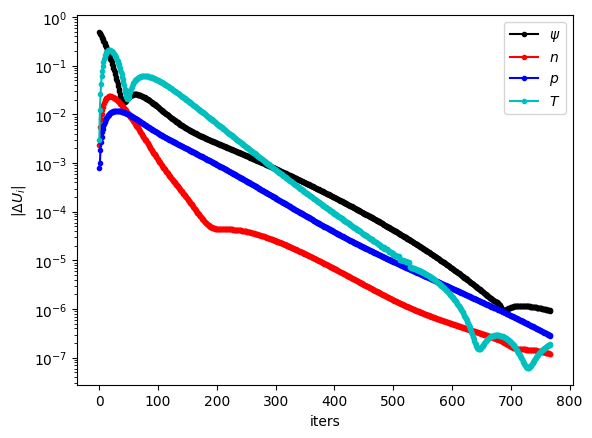

In [21]:
time_thermal_pt = time.time()
U, T = solve_loosely_coupled()
time_thermal_pt = time.time() - time_thermal_pt

Time loosely coupled thermal (pseudo-time stepping: 5.390509605407715 s


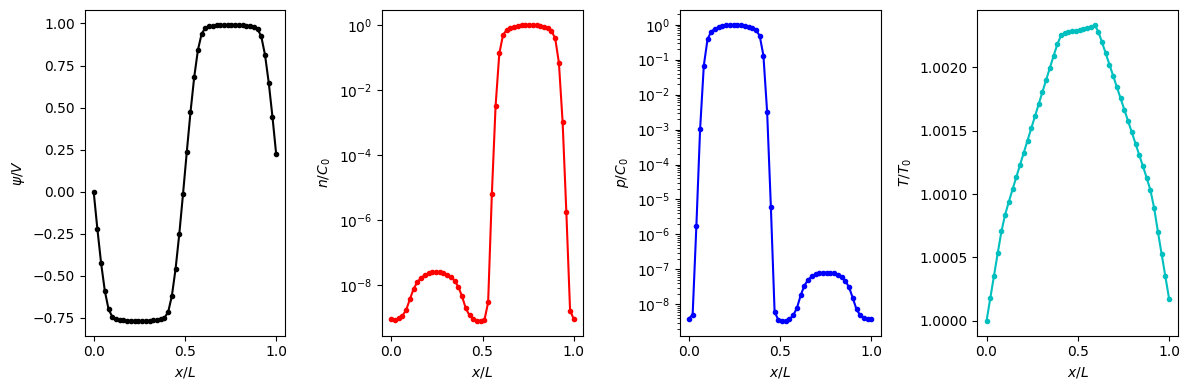

In [22]:
print(f"Time loosely coupled thermal (pseudo-time stepping: {time_thermal_pt} s")
plot_solution(U, T)

# Sympy eigenvalues
The below analysis computes the system eigenvalues at two edge cases: 1) mu*F*ds/T large and 2) mu*F*ds/T small. The real eigenvalues will lay somewhere in the middle. The analysis, though, highlights the relationship of the eigenvalues with the different non-dimensional parameters. 

In [23]:
# import sympy as sp

# N = 6
# e = sp.Symbol("e")
# ds = sp.Symbol("ds")
# mn = sp.Symbol("mn") # mu
# mp = sp.Symbol("mp") # mu
# T = sp.Symbol("T")
# F = sp.Symbol("F")

# def compute_symbolic_jacobian(Bn,  nBn, Bp, nBp):
#     J = sp.zeros(3*N, 3*N)
#     for i in range(N):
#         ip1, im1 = plus_minus_indeces(i)
        
#         J[i,im1] = e / ds
#         J[i,i] = - 2 * e / ds
#         J[i,ip1] = e / ds
    
#         # p and n terms
#         J[i, N + i] = ds
#         J[i, 2*N + i] = - ds
        
#         # n terms
#         J[N+i, N+im1] = mn * T/ds * Bn
#         J[N+i, N+i] = -mn * T/ds * (Bn + nBn)
#         J[N+i, N+ip1] = mn * T/ds * nBn
        
#         # p terms
#         J[2*N+i, 2*N+im1] = mp * T/ds * nBp
#         J[2*N+i, 2*N+i] = -mp * T/ds * (nBp + Bp)
#         J[2*N+i, 2*N+ip1] = mp * T/ds * Bp
#     # print(J)
#     return J.eigenvals()

# # F -> infty
# Bn = 0
# nBn = -F*ds/T

# Bp = 0
# nBp = -F*ds/T

# eig = compute_symbolic_jacobian(Bn,  nBn, Bp, nBp)
# print("Convective eigns. ", eig)

In [24]:
# Bn = mn*F*ds/T/(sp.exp(mn*F*ds/T) - 1)
# nBn = -mn*F*ds/T/(sp.exp(-mn*F*ds/T) - 1)

# Bp = mp*F*ds/T/(sp.exp(mp*F*ds/T) - 1)
# nBp = -mp*F*ds/T/(sp.exp(-mp*F*ds/T) - 1)
# eig = compute_symbolic_jacobian(Bn,  nBn, Bp, nBp)
# print("Diffusive eigns. ", eig)